# Twitter Crypto Sentiment Analysis
##### Author: Isaac Lee  |  Date: 22/02/2022

Is there a correlation between Twitter sentiment and the close price of the a coin?

In [399]:
import pandas as pd
import numpy as np
import my_data_pipelines as mdp
import matplotlib.pyplot as plt
import seaborn as sns
# mdp.my_seaborn_defaults()

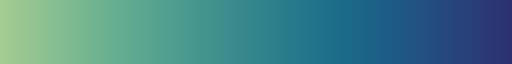

In [400]:
# Set default fig size
sns.set(rc={"figure.figsize":(23, 12)})
sns.set_context("poster")
palette = 'crest'
sns.set_palette(palette)
# When we need two contrasting colors
my_colors = ['#6CB190', '#1D2562']
# Display color palette
sns.color_palette(palette, as_cmap=True)

In [401]:
curr_pair = "USDT_XRP"

## Price Data
---------

In [402]:
price_df = pd.read_csv(f"Data/Price/{curr_pair}_hourly_candles_2017-2022.csv", index_col=0, parse_dates=True)

#### Descriptive Analysis

In [403]:
price_df.head(3)

,weightedAverage,close,high,low,open,volume
date,,,,,,
2017-01-01 01:00:00,8.214461,8.242144,8.242144,8.177586,8.177586,4506.786579
2017-01-01 02:00:00,8.287575,8.400000,8.400000,8.242144,8.242144,10049.610443
2017-01-01 03:00:00,8.476974,8.500091,8.501844,8.387502,8.400000,42440.048838


In [404]:
price_df.isna().sum()

weightedAverage    0
close              0
high               0
low                0
open               0
volume             0
dtype: int64

In [405]:
# Add 24hr rolling average for weightedAverage
price_df['weightedAverage_MA'] = price_df['weightedAverage'].rolling(24*30).mean()

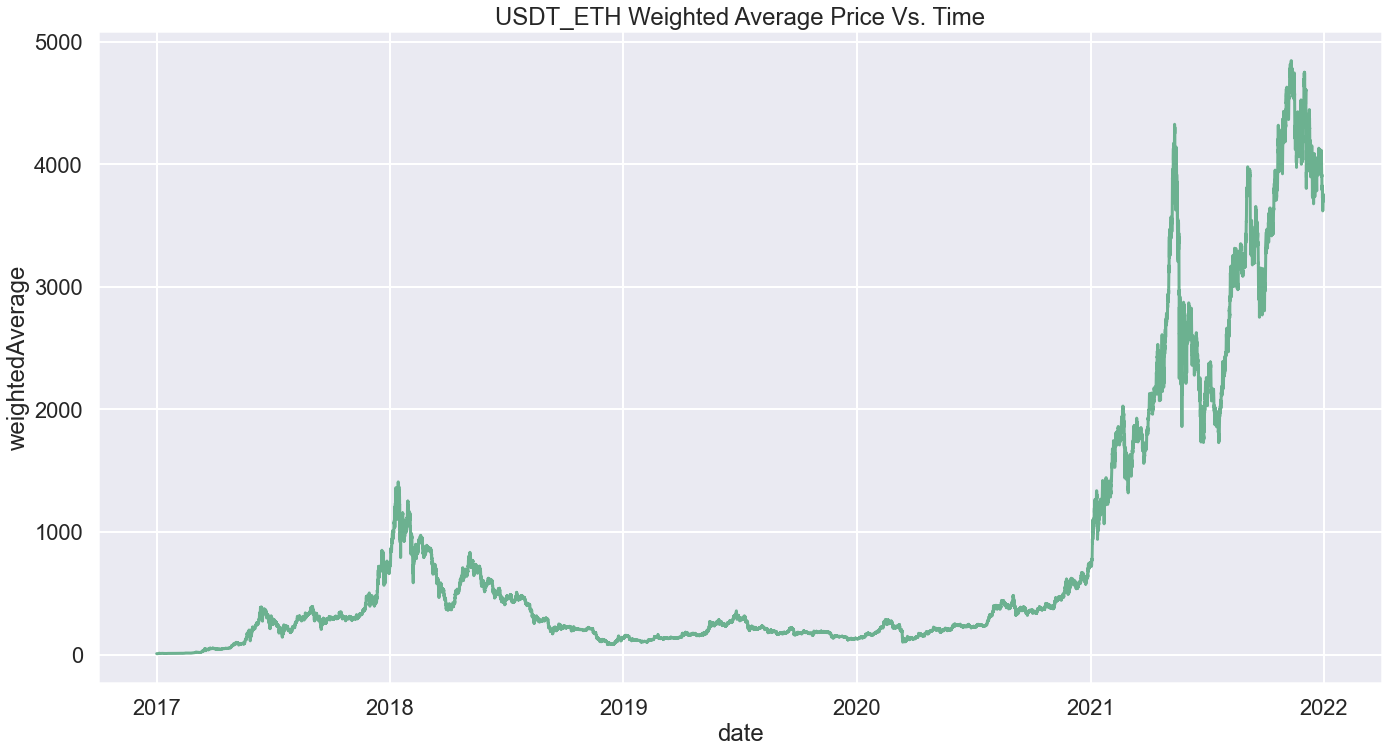

In [406]:
p = sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', color=my_colors[0]).set(title=f'{curr_pair} Weighted Average Price Vs. Time')

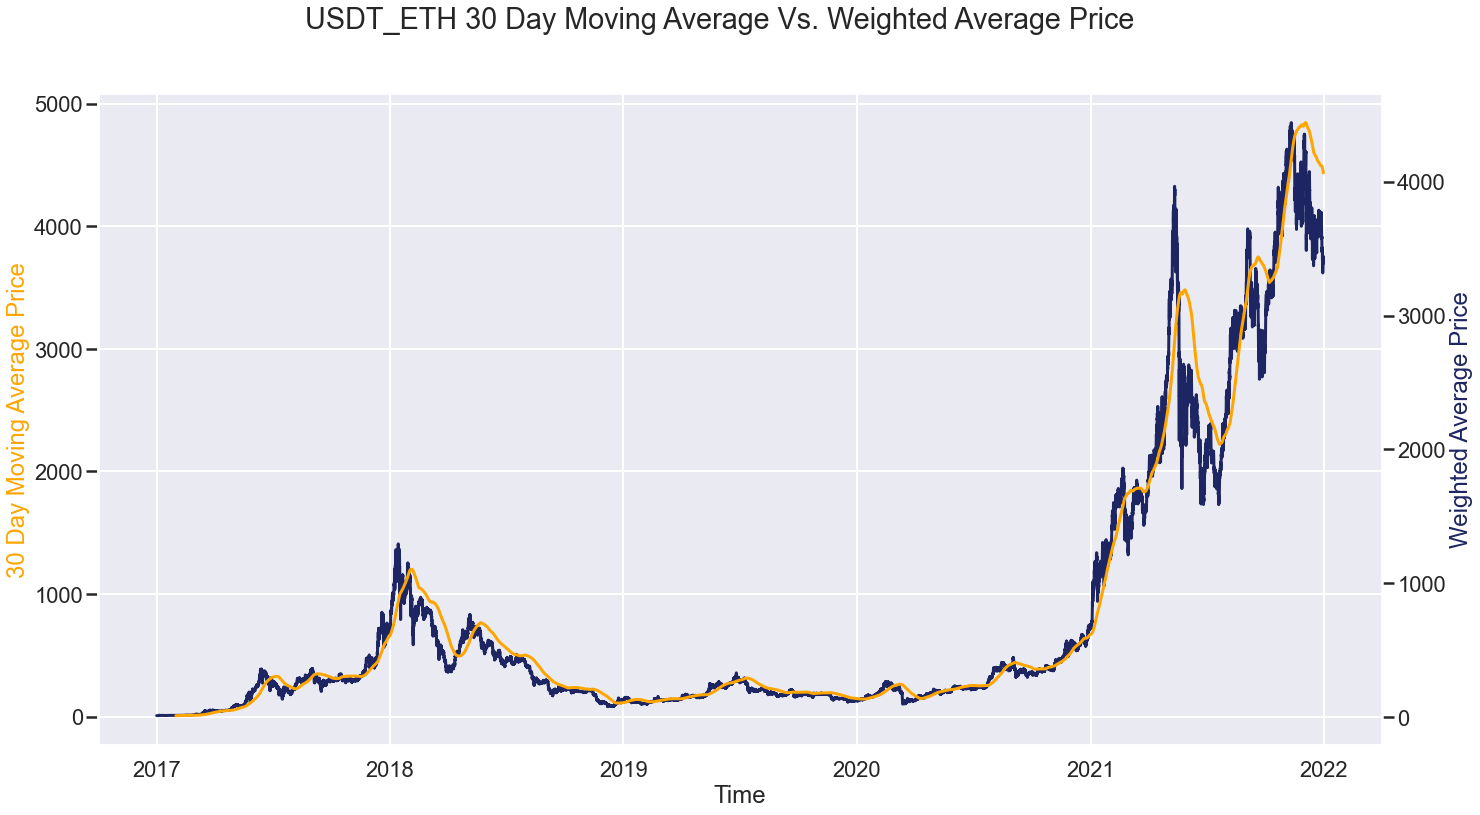

In [407]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', ax=ax1, color=my_colors[1])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage_MA', ax=ax2, color='orange')

ax1.set_xlabel('Time')
ax1.set_ylabel('30 Day Moving Average Price', color='orange')
ax2.set_ylabel('Weighted Average Price', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'{curr_pair} 30 Day Moving Average Vs. Weighted Average Price')

plt.show()

In [408]:
price_df.dtypes

weightedAverage       float64
close                 float64
high                  float64
low                   float64
open                  float64
volume                float64
weightedAverage_MA    float64
dtype: object

In [409]:
mdp.scroll_df(price_df)

interactive(children=(IntSlider(value=0, description='row_idx', max=43705), Dropdown(description='Sort by', in…

## Twitter Data
----------------------------------

### Scraping Tweets
We used a custom scraper script which uses the twint python module
to scrape twitter for tweets and then save the result as a csv.
This is a much better solution than using the twitter api because
we aren't restricted to the number of tweets we can get or the timeframe.  
  
Twint Documentation: https://pypi.org/project/twint/

Useful article: 
https://towardsdatascience.com/analyzing-tweets-with-nlp-in-minutes-with-spark-optimus-and-twint-a0c96084995f

Interesting analysis: https://gigaom.com/2014/04/19/i-analyzed-more-than-a-million-bitcoin-tweets-heres-what-that-looks-like/ 

An example of how to use the scraper.py script:

In [410]:
# This is so we don't accidentily run the cell,
# since it is just to demonstrate the functionality 
# of the scraper script. If you do actually want
# to run the cell then set to True, however I would
# recommend running from the command line.
run_this_cell = False

if run_this_cell:
    from scraper import Scraper
    # Note: max tweets per day == 20
    sc = Scraper(srch_qry="ethereum",
                 start_date="2021-01-01", # The date to start scraping from
                 num_days=365, # The number of days to scrape for
                 min_retweets=50) # Reduce this for more tweets

    sc.scrape_to_csv("Data/example.csv")

In [411]:
# Combine individual year csv's and save to combined csv
# df = pd.DataFrame()
# for year in range(2021, 2016, -1):
#     next_df = pd.read_csv(f"Data/Tweets/{curr_pair}_tweets_{year}.csv", index_col=0, parse_dates=True)
#     df = pd.concat([df, next_df], axis=0) 

# df.to_csv(f"Data/Tweets/{curr_pair}_tweets_2017-2022.csv", index=True)

We combine all of our yearly data for the past five years into
a single dataframe and save it as a csv for later use:

In [412]:
# Read in our dataframe, so that we don't have to combine
# every time.
twt_df = pd.read_csv(f"Data/Tweets/{curr_pair}_tweets_2017-2022.csv", index_col='time')
# Convert index of strings to index of DateTime objects
twt_df.index = pd.DatetimeIndex(pd.to_datetime(twt_df.index, utc=True)).date

In [413]:
twt_df.head(1)

,txt,name,username,likes,retweets,replies
2021-12-30,Which one of these is happening first in 2022?...,Watcher.Guru,watcherguru,2843.0,477.0,1565.0


In [414]:
twt_df.isna().sum()

txt         0
name        0
username    0
likes       0
retweets    0
replies     0
dtype: int64

In [415]:
print("Before conversion: ")
print("------------------------------------")
print(twt_df.dtypes)
# Convert from float to int
twt_df['likes'] = twt_df['likes'].astype(np.int64)
twt_df['retweets'] = twt_df['retweets'].astype(np.int64)
twt_df['replies'] = twt_df['replies'].astype(np.int64)
print("")
print("After conversion: ")
print("------------------------------------")
print(twt_df.dtypes)

Before conversion: 
------------------------------------
txt          object
name         object
username     object
likes       float64
retweets    float64
replies     float64
dtype: object

After conversion: 
------------------------------------
txt         object
name        object
username    object
likes        int64
retweets     int64
replies      int64
dtype: object


In [416]:
# Remove all characters that are not alphanumeric or spaces
twt_df['txt'] = twt_df['txt'].apply(mdp.remove_non_alpha)

In [417]:
mdp.scroll_df(twt_df)

interactive(children=(IntSlider(value=0, description='row_idx', max=1995), Dropdown(description='Sort by', ind…

In [418]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/isaac/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [419]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [420]:
twt_df['neg'] = twt_df['txt'].apply(lambda txt: sia.polarity_scores(txt)['neg'])
twt_df['neu'] = twt_df['txt'].apply(lambda txt: sia.polarity_scores(txt)['neu'])
twt_df['pos'] = twt_df['txt'].apply(lambda txt: sia.polarity_scores(txt)['pos'])
twt_df['compound'] = twt_df['txt'].apply(lambda txt: sia.polarity_scores(txt)['compound'])

In [421]:
twt_df.head(3)

,txt,name,username,likes,retweets,replies,neg,neu,pos,compound
2021-12-30,Which one of these is happening first in 2022 ...,Watcher.Guru,watcherguru,2843,477,1565,0.000,1.000,0.000,0.0000
2021-12-30,On this day one year ago 1 Bitcoin 2884157 1 ...,The Moon,themooncarl,776,176,223,0.000,1.000,0.000,0.0000
2021-12-30,Its hard to believe that the Gas Dao is less t...,"Gas DAO (⛽,⛽)",0xgasdao,673,177,124,0.047,0.845,0.108,0.4201


In [422]:
mdp.scroll_df(twt_df)

interactive(children=(IntSlider(value=0, description='row_idx', max=1995), Dropdown(description='Sort by', ind…

In [423]:
# Binning the compound score into negative or positive and getting the proportions of each
twt_df['binnedCompound'] = twt_df['compound'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')
twt_df['binnedCompound'].value_counts()

positive    1083
neutral      597
negative     316
Name: binnedCompound, dtype: int64

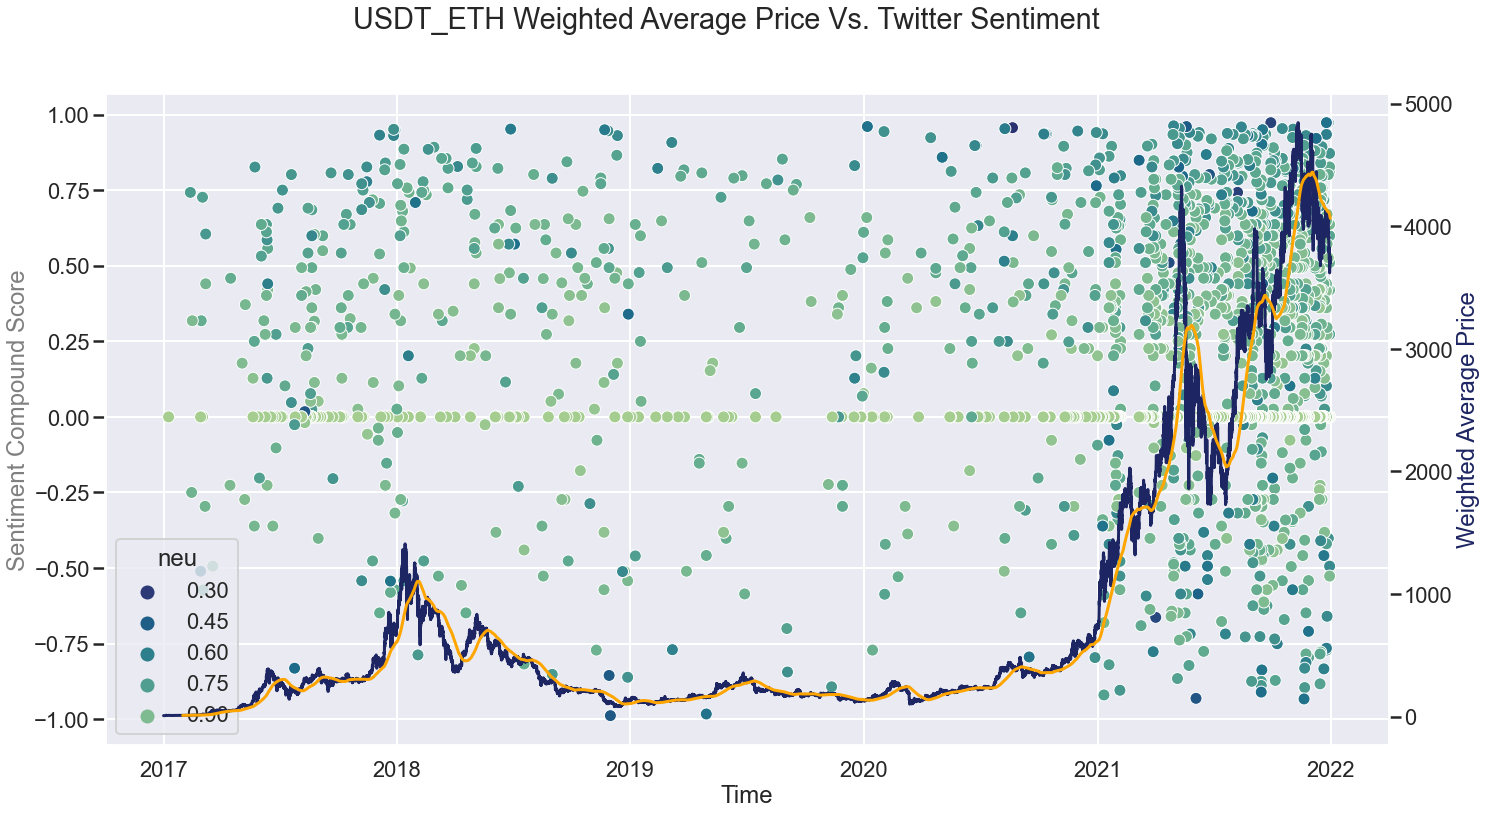

In [424]:

fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(data=twt_df.reset_index(), x='index', y='compound', ax=ax1, color='gray', hue='neu', palette=palette + '_r')
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', ax=ax2, color=my_colors[1])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage_MA', ax=ax2, color='orange')

ax1.set_xlabel('Time')
ax1.set_ylabel('Sentiment Compound Score', color='gray')
ax2.set_ylabel('Weighted Average Price', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'{curr_pair} Weighted Average Price Vs. Twitter Sentiment')

plt.savefig(f'Findings/Images/{curr_pair}_price_vs_sentiment_2017-2022.png')
plt.show()

We can see that most of the points are very neutral, suggesting either our sentiment
model needs to be improved or most of the tweets were just very neutral.
To try and make things more clear we can filter out the neutral tweets:


In [425]:
threshold = 0.1
# Filter only tweets with a positive compound sentiment above the threshold
pos_twt_df = twt_df.loc[(twt_df.pos > threshold)]
# Filter only tweets with a negative compound sentiment above the threshold
neg_twt_df = twt_df.loc[(twt_df.neg > threshold)]

pos_twt_df.head(2)

,txt,name,username,likes,retweets,replies,neg,neu,pos,compound,binnedCompound
2021-12-30,Its hard to believe that the Gas Dao is less t...,"Gas DAO (⛽,⛽)",0xgasdao,673,177,124,0.047,0.845,0.108,0.4201,positive
2021-12-30,Staking for Ethereum 2 is a storybook example ...,stefan huber.truth,leerzeit,298,89,19,0.000,0.802,0.198,0.8126,positive


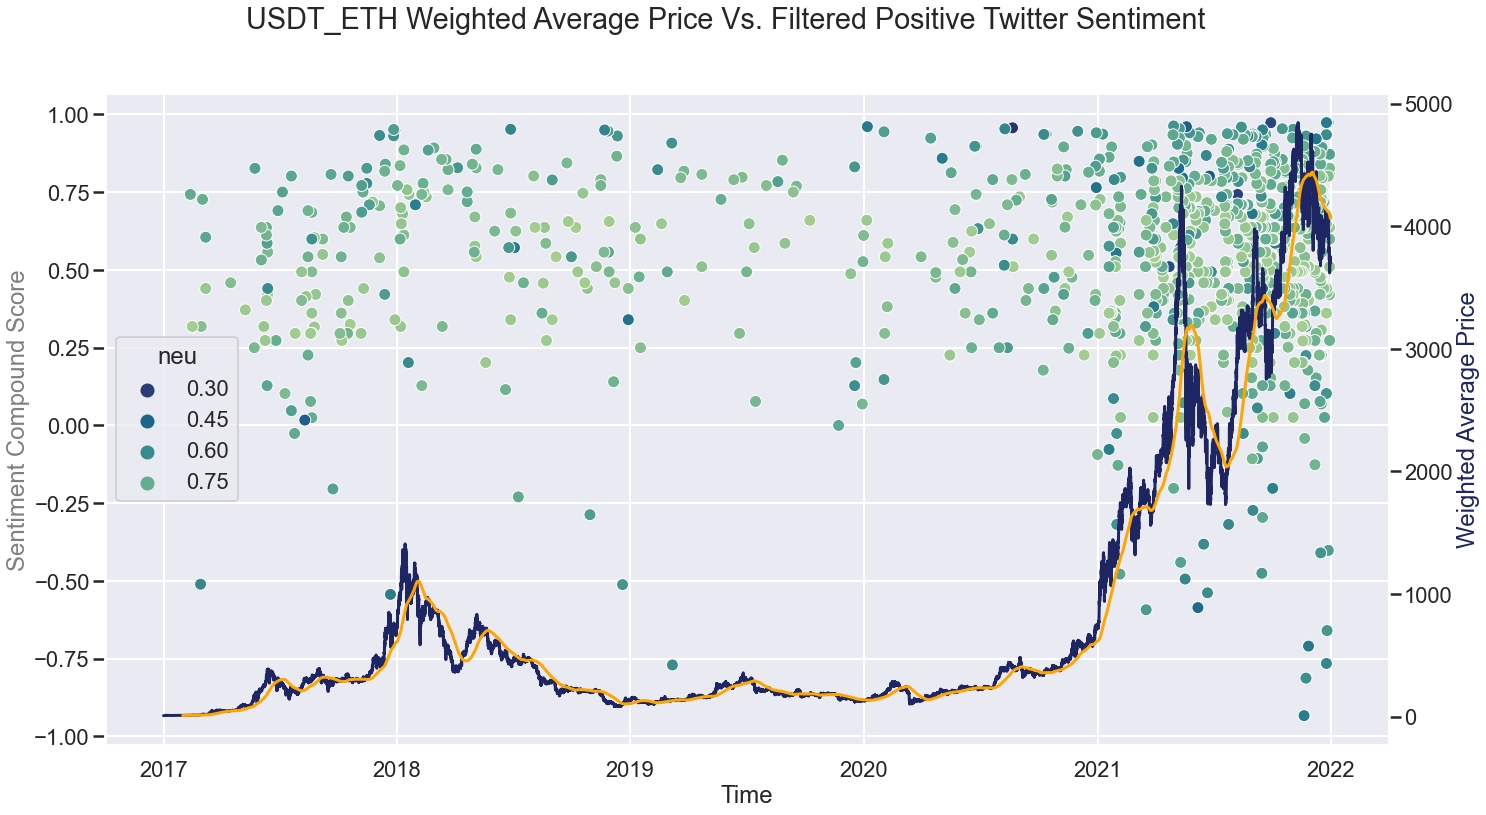

In [426]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(data=pos_twt_df.reset_index(), x='index', y='compound', ax=ax1, color='gray', hue='neu', palette=palette + '_r')
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', ax=ax2, color=my_colors[1])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage_MA', ax=ax2, color='orange')

ax1.set_xlabel('Time')
ax1.set_ylabel('Sentiment Compound Score', color='gray')
ax2.set_ylabel('Weighted Average Price', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'{curr_pair} Weighted Average Price Vs. Filtered Positive Twitter Sentiment')

plt.savefig(f'Findings/Images/{curr_pair}_price_vs_pos_sentiment_2017-2022.png')
plt.show()

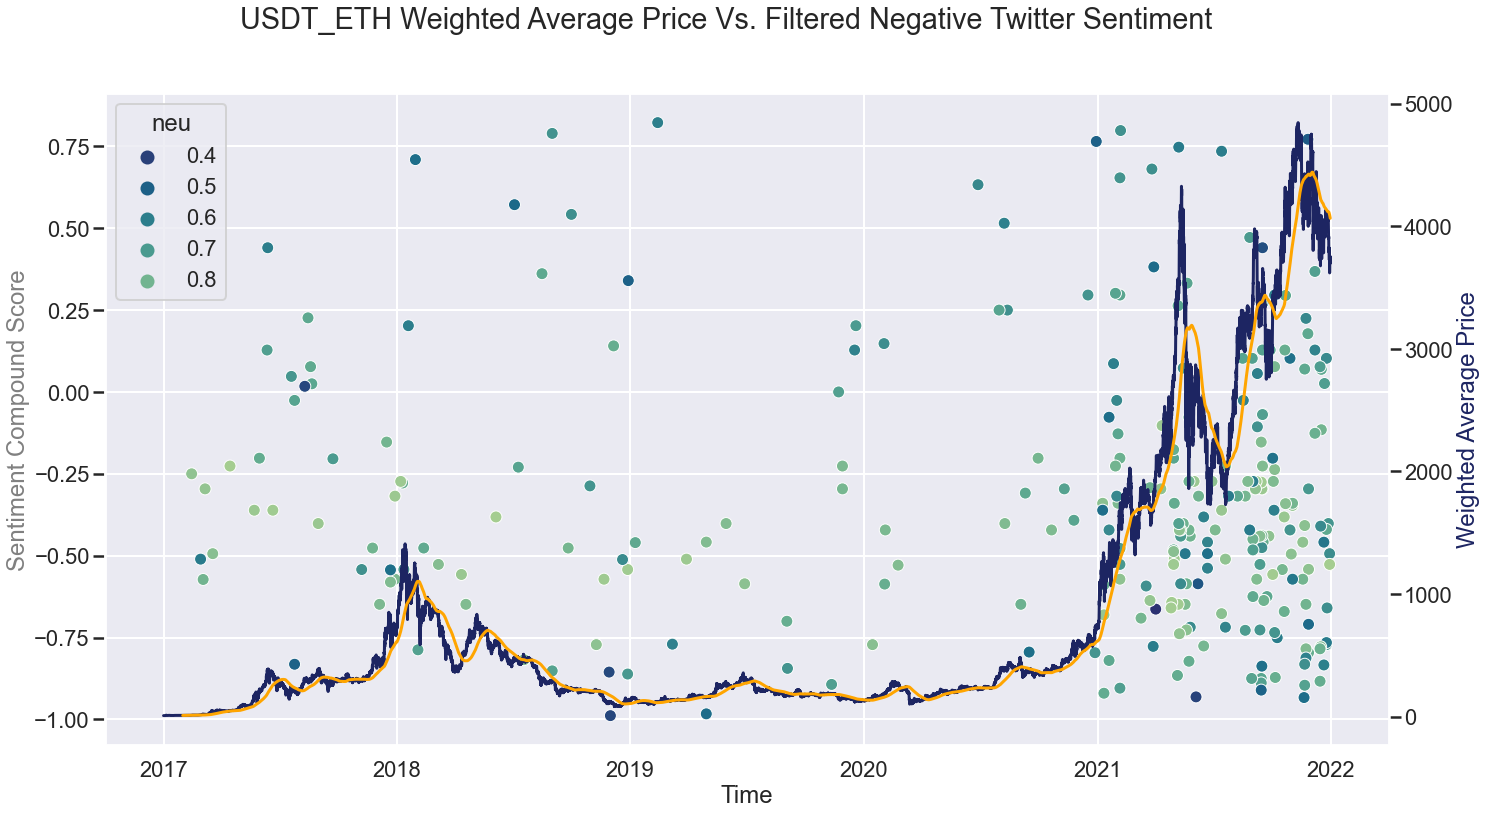

In [427]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(data=neg_twt_df.reset_index(), x='index', y='compound', ax=ax1, color='gray', hue='neu', palette=palette + '_r')
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', ax=ax2, color=my_colors[1])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage_MA', ax=ax2, color='orange')

ax1.set_xlabel('Time')
ax1.set_ylabel('Sentiment Compound Score', color='gray')
ax2.set_ylabel('Weighted Average Price', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'{curr_pair} Weighted Average Price Vs. Filtered Negative Twitter Sentiment')

plt.savefig(f'Findings/Images/{curr_pair}_price_vs_neg_sentiment_2017-2022.png')
plt.show()

We can also ask: how does the frequency of tweets correlate to price movement?
To do this we make a new DataFrame which groups and counts the tweets by day:

In [428]:
# Make a new df with a time index and single column corresponding to the number of tweets
# on that day.
twt_count_df = pd.DataFrame(columns=["twtCount"], data=twt_df.index.value_counts().sort_index())
twt_count_df

,twtCount
2017-01-09,1
2017-02-12,1
2017-02-14,1
2017-02-15,1
2017-02-28,2
...,...
2021-12-22,6
2021-12-25,13
2021-12-26,12
2021-12-28,9


In [429]:
# Filter the DataFrame to only have positive sentiment tweets
pos_twt_df = twt_df[twt_df['compound'] > 0]
pos_twt_count_df = pd.DataFrame(columns=['twtCounts'], data=pos_twt_df.index.value_counts()).sort_index(ascending=False)

# Filter the DataFrame to only have negative sentiment tweets
neg_twt_df = twt_df[twt_df['compound'] < 0]
neg_twt_count_df = pd.DataFrame(columns=['twtCounts'], data=neg_twt_df.index.value_counts()).sort_index(ascending=False)
neg_twt_df.head(1)

,txt,name,username,likes,retweets,replies,neg,neu,pos,compound,binnedCompound
2021-12-30,Drop your Ethereum address Randomly drop NFT ...,Crypto Bolt Giveaways ⚡️,cryptoboltx,1034,1211,1325,0.344,0.656,0.0,-0.4939,negative


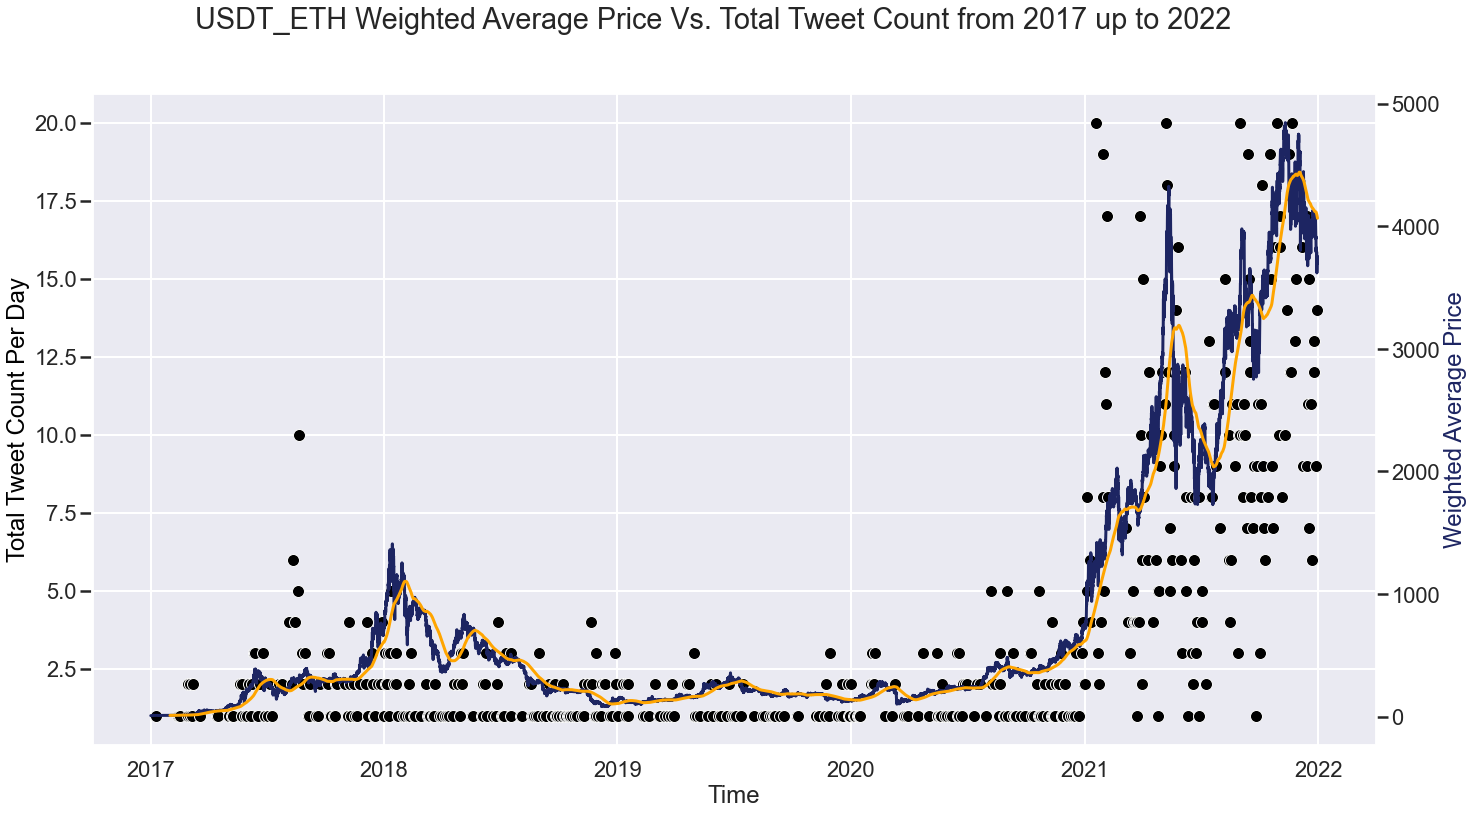

In [430]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(data=twt_count_df.reset_index(), x='index', y='twtCount', ax=ax1, color='black')
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', ax=ax2, color=my_colors[1])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage_MA', ax=ax2, color='orange')

ax1.set_xlabel('Time')
ax1.set_ylabel('Total Tweet Count Per Day', color='black')
ax2.set_ylabel('Weighted Average Price', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'{curr_pair} Weighted Average Price Vs. Total Tweet Count from 2017 up to 2022')

plt.savefig(f'Findings/Images/{curr_pair}_price_vs_total_tweet_count_2017-2022.png')
plt.show()

So interestingly it seems that people tend to post the most when bitcoin is doing well and perhaps less when it is doing worse.  
This would make sense if people are invested, they have rose tinted goggles and would be more reluctant to say anything bad
about bitcoin.

Exploring this idea further, we can explore the number frequency of negative and positive tweets per day:

In [431]:
# Filter the DataFrame to only have positive sentiment tweets
pos_twt_df = twt_df[twt_df['compound'] > 0]
pos_twt_count_df = pd.DataFrame(columns=['twtCounts'], data=pos_twt_df.index.value_counts()).sort_index(ascending=False)

# Filter the DataFrame to only have negative sentiment tweets
neg_twt_df = twt_df[twt_df['compound'] < 0]
neg_twt_count_df = pd.DataFrame(columns=['twtCounts'], data=neg_twt_df.index.value_counts()).sort_index(ascending=False)
neg_twt_df.head(1)

,txt,name,username,likes,retweets,replies,neg,neu,pos,compound,binnedCompound
2021-12-30,Drop your Ethereum address Randomly drop NFT ...,Crypto Bolt Giveaways ⚡️,cryptoboltx,1034,1211,1325,0.344,0.656,0.0,-0.4939,negative


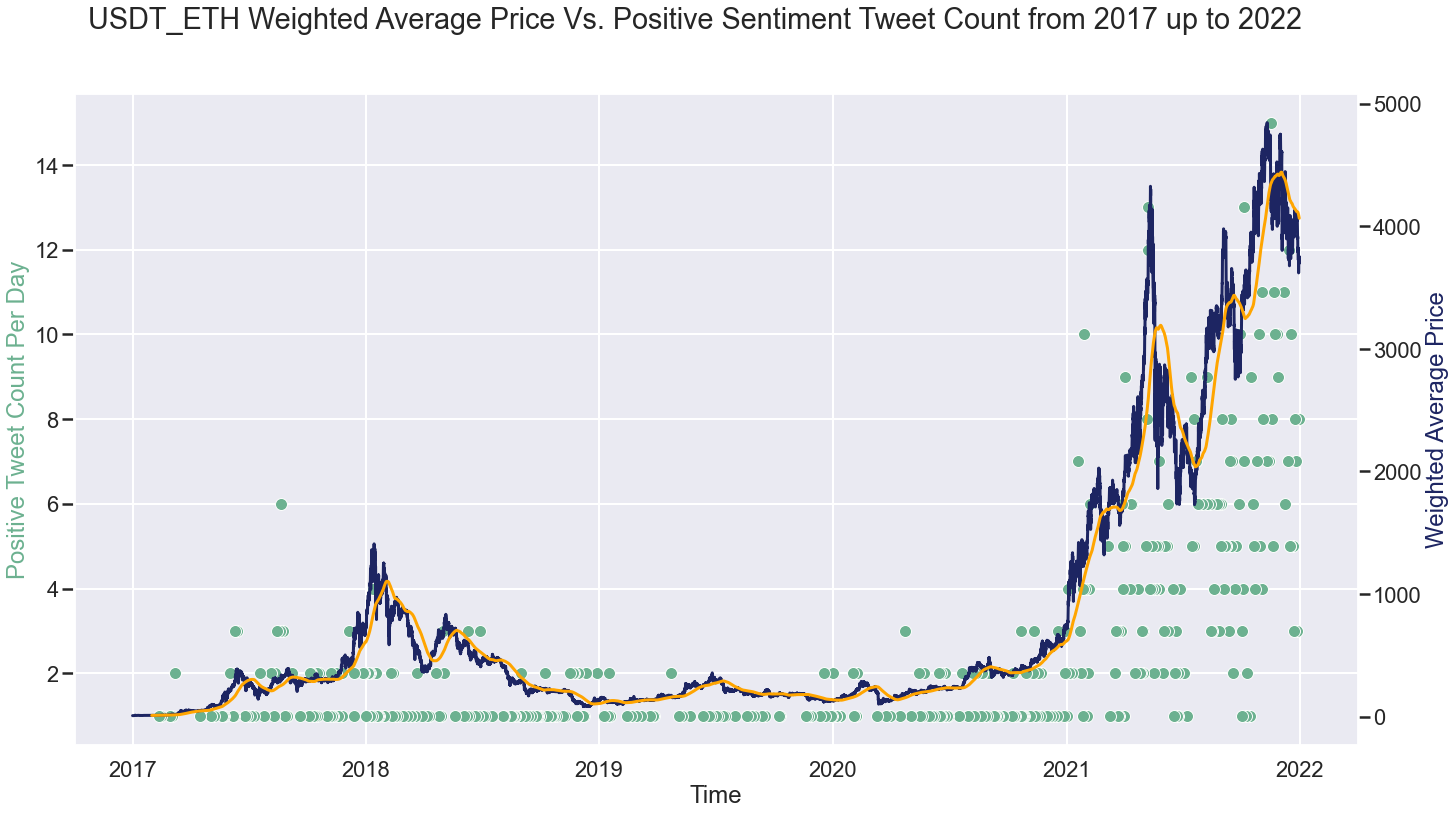

In [432]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.scatterplot(data=pos_twt_count_df.reset_index(), x='index', y='twtCounts', ax=ax1, color=my_colors[0])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', ax=ax2, color=my_colors[1])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage_MA', ax=ax2, color='orange')

ax1.set_xlabel('Time')
ax1.set_ylabel('Positive Tweet Count Per Day', color=my_colors[0])
ax2.set_ylabel('Weighted Average Price', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'{curr_pair} Weighted Average Price Vs. Positive Sentiment Tweet Count from 2017 up to 2022')

plt.savefig(f'Findings/Images/{curr_pair}_price_vs_pos_tweet_count_2017-2022.png')
plt.show()

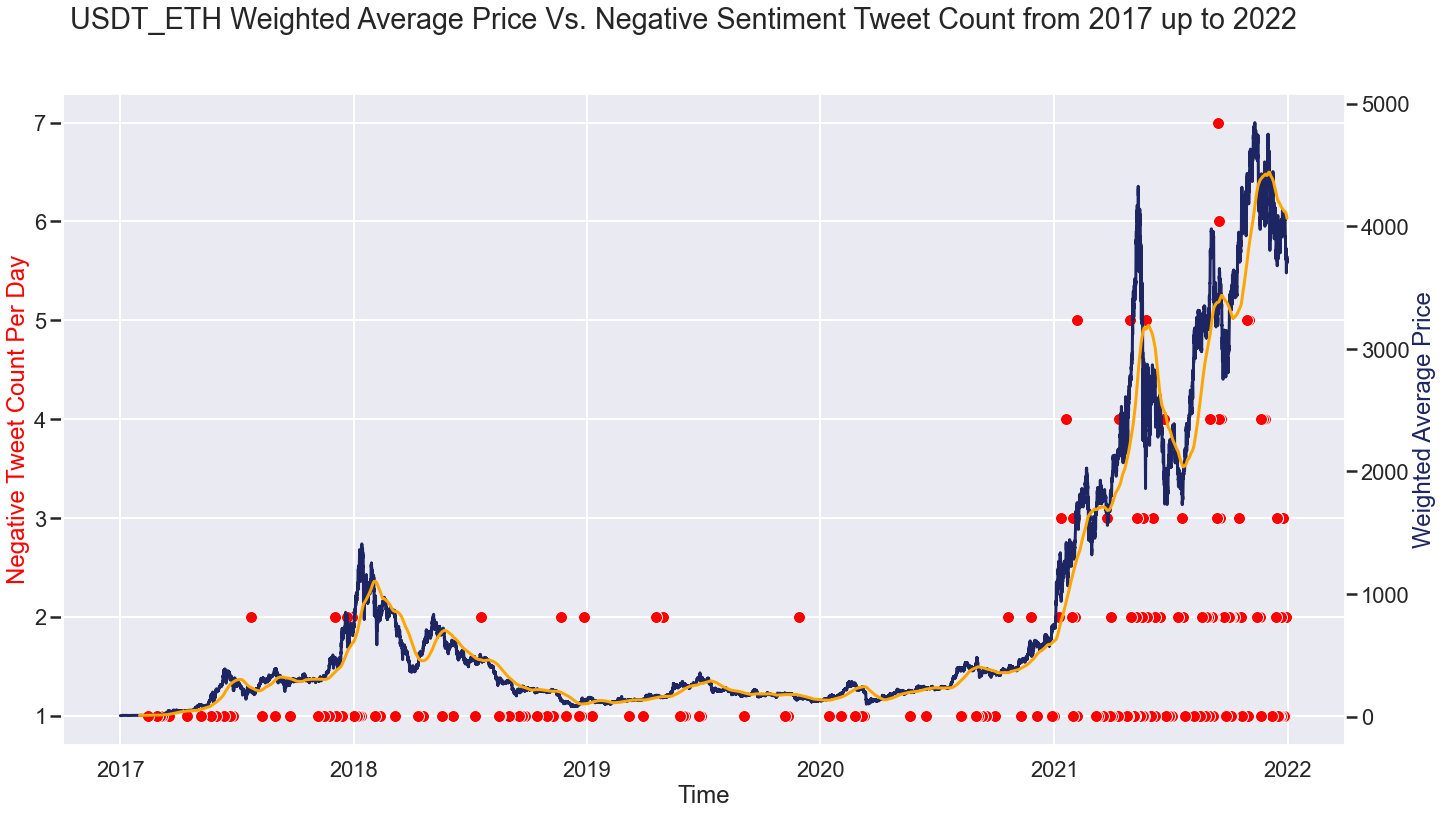

In [433]:
fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage', ax=ax2, color=my_colors[1])
sns.lineplot(data=price_df.reset_index(), x='date', y='weightedAverage_MA', ax=ax2, color='orange')
sns.scatterplot(data=neg_twt_count_df.reset_index(), x='index', y='twtCounts', ax=ax1, color='red')

ax1.set_xlabel('Time')
ax1.set_ylabel('Negative Tweet Count Per Day', color='red')
ax2.set_ylabel('Weighted Average Price', color=my_colors[1])
ax2.grid(False)
fig.suptitle(f'{curr_pair} Weighted Average Price Vs. Negative Sentiment Tweet Count from 2017 up to 2022')

plt.savefig(f'Findings/Images/{curr_pair}_price_vs_neg_tweet_count_2017-2022.png')
plt.show()